In [1]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import cv2
from torchvision.transforms import v2
from torchvision.io import read_image
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torchvision.ops as ops
from IPython.display import Image

# [VGG16](https://pytorch.org/vision/master/models/vgg.html)

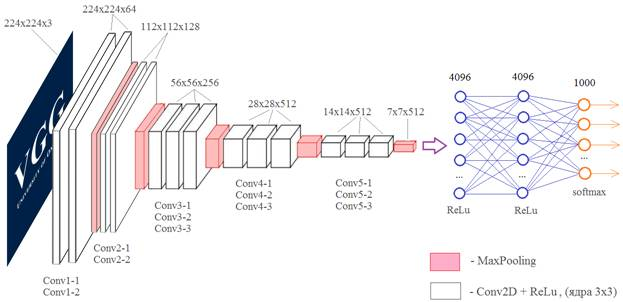

In [2]:
Image("vgg16.jpg", width=800)

**[статья](https://proproprogs.ru/nn_pytorch/pytorch-svertochnye-neyronnye-seti-vgg-16-i-vgg-19)**

Архитектура **VGG16**, которая состоит из 16 слоев: 13 сверточных и 3 полносвязных. В нем используются только **3x3** фильтры, причем несколько сверточных слоев с одинаковым числом фильтров и с одинаковым размером карт признаков, которые они выдают, идут как бы вместе. Можно было бы объединить эти сверточные слои в один, но с большими размерами ядер. Например, 2 подряд идущих сверточных слоя с 64 фильтрами и размерами карт признаков **224x224** можно было бы объединить в один сверточный слой, но с размером ядра **5x5**. Это эквивалентно, потому что 2 подряд идущих сверточных слоя с размерами ядер **3x3** охватывают ту же область в исходном изображении, что и один сверточный слой с размером ядра 5x5. Причина, по которой так не делают, заключается в том, что обучаемых параметров в случае **5x5** ядер будет больше:

$5*5+1 = 26$ (в случае одного ядра 5x5, +1 $-$ bias)

$2*(3*3+1) = 20$ (в случае двух ядер 3x3, +1 $-$ bias)

А еще nvidia оптимизировала операции как раз таки для ядер размером **3x3**, так как они стали наиболее популярны в архитектурах нейросетей.

На картинке сверху видно, что число фильтров растет с ростом глубины нейронной сети (от 64 до 512), это происходит потому, что в самом начале необходимо находить несложные паттерны (черточки, переходы яркостей под разными углами), а в конце появляются более сложные паттерны, их разнообразие больше, поэтому под них нужно больше фильтров.

Число фильтров увеличивается в 2 раза для того, чтобы в каждом слое требовалось примерно столько же вычислительных ресурсов, как и в следующем, а размерность карт признаков уменьшается в 2 раза, чтобы увеличивать **receptive field**, чтобы с ростом глубины нейросети каждый нейрон мог получать информацию все с большей области в исходном изображении. Например, в каком-то слое требовалось **n** операции и на следующем слое делается **max pooling** и увеличивается число фильтров в 2 раза. Тогда, чтобы получить число операции на следующих слоях, нужно разделить **n** на 4, так как ширина и высота карт признаков уменьшается в 2 раза, и умножить на 4, так как число фильтров и каждый отдельный фильтр станет больше в 2 раза. Это приводит к тому, что количество вычислении на каждом слое остается примерно одинаковым.

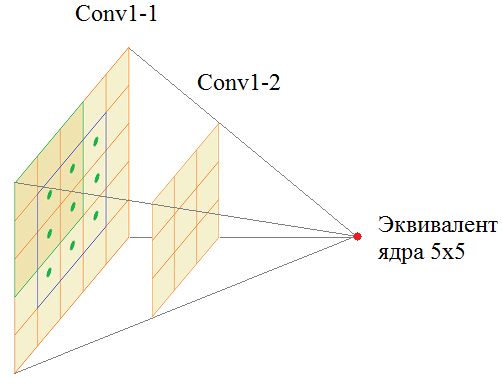

In [3]:
Image("vgg_conv.png", width=500)

# Модель VGG16 в PyTorch

In [4]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),  
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        out = self.avgpool(out)
        
        out = self.classifier(out)
        return out

In [5]:
x = torch.randn(1, 3, 128, 128)

In [6]:
%%time
VGG16(2)(x)

CPU times: total: 797 ms
Wall time: 804 ms


tensor([[ 0.2466, -0.0234]], grad_fn=<AddmmBackward0>)

# Создаем Dataset и Dataloader

In [2]:
class CatsDogsDataset(Dataset):
    def __init__(self, path, train=True, transform=None):
        self.path = os.path.join(path, "train" if train else "test")
        self.images = os.listdir(self.path)
        random.shuffle(self.images)
        self.labels = [int(img[0]) for img in self.images]
        self.length = len(self.labels)
        self.target = torch.eye(2)
        self.transform = transform
        self.train = train
    
    def __getitem__(self, indx):
        image = cv2.imread(os.path.join(self.path, self.images[indx])) 
        image = torch.from_numpy(image).permute(2, 0, 1) / 255
        label = self.labels[indx]
        target = self.target[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target
    
    def __len__(self):
        return self.length

In [3]:
path = r"datasets\dogs_and_cats"

In [4]:
transforms = v2.Compose( [v2.Resize((500, 500)),
                          v2.RandomCrop((450, 450)),
                          v2.RandomAffine(degrees=(-10, 10), 
                                          translate=(0.05, 0.05), 
                                          scale=(0.95, 1.05), 
                                          shear=(-3, 3), 
                                          fill=(0)),
                          v2.RandomPhotometricDistort(), 
                          v2.RandomHorizontalFlip()] )

In [5]:
train_dataset = CatsDogsDataset(path, train=True, transform=transforms)
test_dataset = CatsDogsDataset(path, train=False, transform=v2.Resize((450, 450)))

In [6]:
batch_size = 8

In [7]:
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          drop_last=True, 
                          num_workers=0)

In [8]:
test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False, 
                         drop_last=False, 
                         num_workers=0)

# Используем предобученную модель VGG16

In [14]:
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.classifier[6] = nn.Linear(4096, 2).requires_grad_(True)

# Часть слоев замораживаем, чтобы модель быстрее обучилась

In [15]:
model.features = model.features.requires_grad_(False)

In [16]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cuda')

In [19]:
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=10**(-6))
sheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.2, patience=2)
criterion = nn.CrossEntropyLoss().to(device)

In [58]:
epochs = 3

# Обучение

In [21]:
current_accuracy = 0

In [26]:
for epoch in range(1, epochs+1):
    model.train()
    
    progress_bar = tqdm(train_loader,
                        leave=True if epoch == epochs else False,
                        unit="batch")
    
    mean_loss = 0
    m = 0
    
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        value = loss.item()
        m += 1
        mean_loss = 1/m * value + (1 - 1/m) * mean_loss
        
        text = f"[train] Epoch: [{epoch}/{epochs}] <Loss>: {mean_loss:.2f}|"
        progress_bar.set_description(text)
        
    model.eval()
    value = 0
    m = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)
            
        m += labels.shape[0]
        value += (predicted == labels).sum().item()
        
    accuracy = 100 * value / m
    sheduler.step(accuracy)
    
    if accuracy > current_accuracy:
        current_accuracy = accuracy
        best_model = model.state_dict()

[train] Epoch: [3/3] <Loss>: 0.29|: 100%|███████████████████████████████████████| 1247/1247 [07:06<00:00,  2.92batch/s]


In [27]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [28]:
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
            
        outputs = model(images)
            
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)
            
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
        
accuracy = 100 * correct / total

100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [01:05<00:00,  4.74it/s]


In [29]:
accuracy

95.89342948717949

# ResNet

**[Статья 1](https://arxiv.org/pdf/1512.03385)** | **[Статья 2](https://arxiv.org/pdf/1603.05027)** | **[Статья 3](https://arxiv.org/pdf/1605.06431)** | **[Статья 4](https://arxiv.org/pdf/1712.09913)**

**[Видео 1](https://www.youtube.com/watch?v=1v1SQUXHcLA)** | **[Видео 2](https://www.youtube.com/watch?v=f8wWhL9bz1Q&t=1s)** | **[Видео 3](https://www.youtube.com/watch?v=T1Ka_kaWvis&list=PL6-BrcpR2C5Q1ivGTQcglILJG6odT2oCY&index=18)**

С появлением **VGG16** и **VGG19** у исследователей появилось желание еще больше увеличивать глубину нейронных сетей, так как количество слоев коррелировало с качеством, которую выдавали нейросети. Однако, чем глубже сеть, тем сложнее ее обучить, особенно из-за проблемы затухающих/взрывающихся градиентов. Чтобы решить эту проблему, предлагается новый подход — Residual Learning.

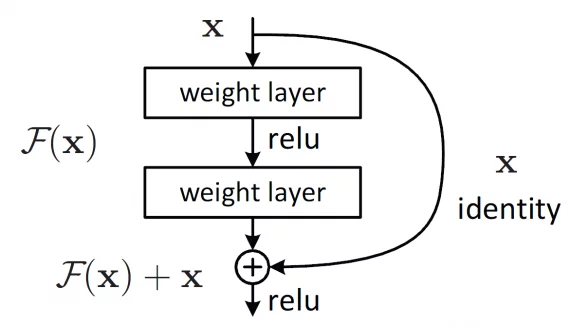

In [31]:
Image("residual.png")

В ResNet каждый слой обучает не прямую трансформацию, а остаточную (residual) функцию: пытается найти разницу (ошибку), которую нужно добавить к предыдущему слою, чтобы получить желаемый результат.

$F(x)=H(x)−x$

$H(x)$ — это целевая функция (желаемый результат), $F(x)$ — это разница, которую нужно научиться моделировать.

Таким образом, сеть учится не на самой целевой функции, а на остаточной разнице, что значительно упрощает обучение.

$H(x)=F(x)+x$

Если продифференцировать функцию потерь $L$ по $x$, то получим $\frac{dL}{dx} = \frac{dL}{dH(x)}\cdot \frac{dH(x)}{dF(x)}\cdot \frac{dF(x)}{dx} + \frac{dL(x)}{dH(x)}\cdot \frac{dH(x)}{dx}=\frac{dL}{dH(x)}\cdot(\frac{dH(x)}{dx} + 1)$ 

В **ResNet** добавляется **+ 1** в формулу обратного распространения ошибки, что позволяет уменьшить влияние исчезающих градиентов, так как сигнал будет доходить в начальные слои модели.

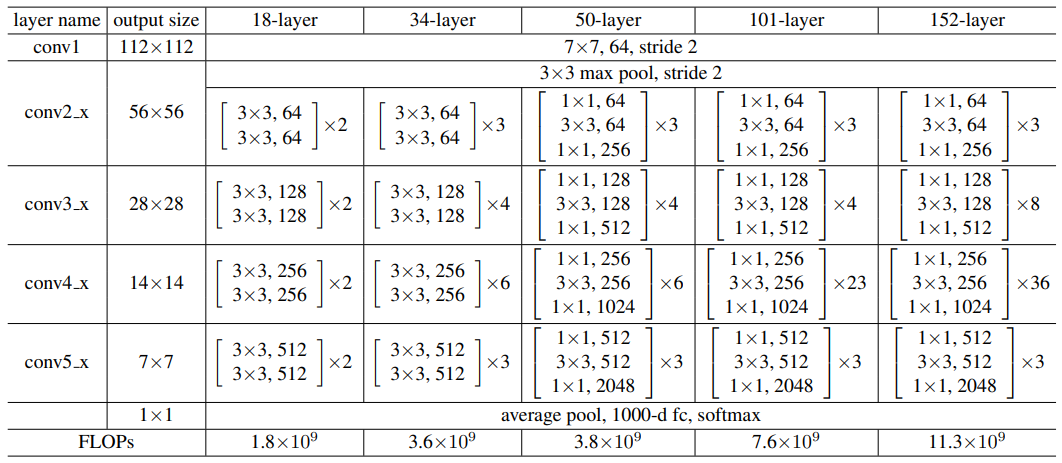

In [285]:
Image("resnet_architectures.png", width=950)

В **ResNet** используются **shortcut connections** — прямые связи (или "переходы"), которые пропускают один или несколько слоев. Эти связи выполняют идентичное отображение: они просто пропускают информацию через слои без изменений, что позволяет сети обучаться быстрее. Добавление таких связей не увеличивает вычислительные затраты, потому что они не добавляют дополнительных параметров, кроме простого сложения входа и выхода.

В [статье 3](https://arxiv.org/pdf/1605.06431) сети с остаточными связями (ResNets) рассматриваются как сеть множества различных путей, проходящих через разные блоки и слои, а не как один непрерывный путь. Эти пути имеют различную длину, и не все пути одинаково важны для обучения. Исследование показывает, что пути в ResNet независимы друг от друга и могут быть удалены без существенного ухудшения результатов, что напоминает поведение ансамблей, где множество моделей работает совместно. Не все пути одинаково важны для обучения и короткие пути играют более важную роль, так как основная часть градиента проходит через короткие пути. Это позволяет очень глубоким сетям обучаться эффективно, избегая проблемы затухающего градиента. Более длинные пути не вносят значительного вклада в обучение, потому что не могут передать градиент эффективно. Таким образом, в исследовании говорится, что Resnet сокращает эффективную длину путей, делая обучение более эффективным даже для очень глубоких сетей.

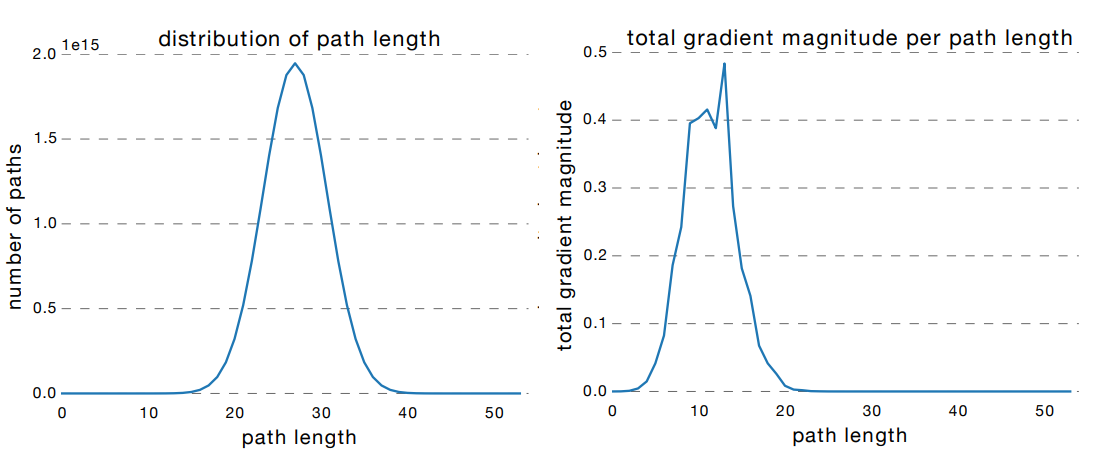

In [36]:
Image("resnet_path.png")

В Residual Networks (ResNets) данные могут проходить через сеть по многим путям. Каждый путь можно представить как уникальную комбинацию того, какие слои обрабатывают данные, а какие пропускают. Количество возможных путей в сети с n модулями равно $2^n$, так как для каждого модуля существует два варианта: либо он включен в путь, либо нет. Исследование показало, что распределение длин путей в ResNet приближается к биномиальному распределению (**график 1**). Это означает, что большинство путей имеют длину около $\frac{n}{2}$, где $n$ — это количество модулей в сети. Здесь под модулем подразумевается строительная единица, которая может состоять из сверточных слоев, BatchNorm, функции активации и из **shortcut connection**.

Также в статье измерили градиент, который протекает по путям разной длины (**график 2**). Для этого измеряются магнитуды градиентов по конкретным путям. Градиент - это вектор из частных производных, а значит у этого вектора можно измерить длину (норму). $||∇_θL||$ = $\sqrt{\sum_{i=1}^n (\frac{dL}{dw_i})^2}$ Это и будет магнитудой градиента, который позволяет понять, какие пути вносят наибольший вклад в обновление параметров модели. В результате оказалось, что основной градиент протекал по путям малой длины (от 5 до 17).

Таким образом, **shortcut connections** позволяют градиенту обходить множество слоёв, что снижает риск затухания градиента. Более короткие пути обеспечивают стабильное и сильное обновление параметров, а более длинные пути позволяют сети быть достаточно мощной для представления сложных зависимостей.

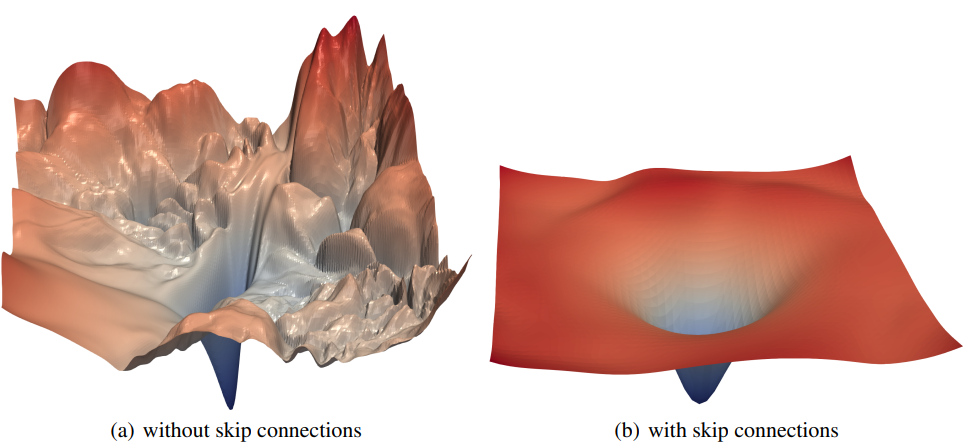

In [37]:
Image("resnet_lanscape.png")

В [Статье 4](https://arxiv.org/pdf/1712.09913) визуализировали ResNet без **shortcut connections** и используя **shortcut connections**. Видно, что во втором случае поверхность функции потерь гораздо более гладкая и поэтому для нее проще найти минимум.

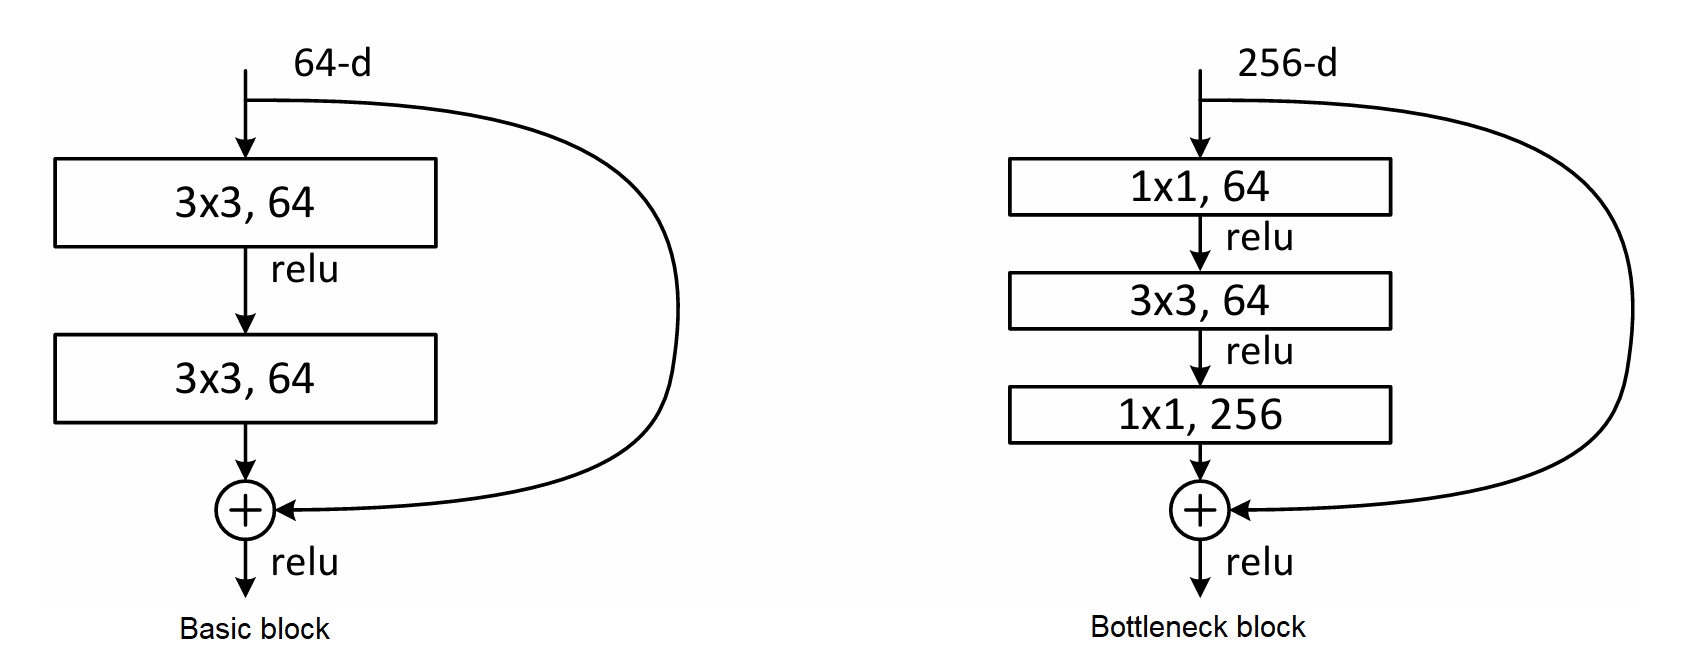

In [4]:
Image("resnet_block.png")

В глубоких архитектурах **resnet** (**resnet50** и выше) используются **bottleneck** блоки, вместо **basic** блоков. Их основная задача в том, чтобы эффективно уменьшить число параметров и выполняемых операции.

В **bottleneck** блоке:
- **Первый** сверточный слой имеет ядро размером **1x1**, а число выходных карт признаков становится меньше в 4 раза на картинке (может быть и другое число, например, в 2 раза). Суть этого слоя в том, чтобы эффективно сжимать данные (число карт признаков), которые в него поступают, оставляя в них только наиболее важные. Это свойство этот слой получает в результате обучения.

- **Второй** сверточный слой имеет ядро размером **3x3** и используется для извлечения признаков, как в **basic** блоке.

- **Третий** сверточный слой имеет ядро размером **1x1**, а число выходных каналов становится таким же, как и при входе в **bottleneck** блок. То есть этот слой используется для восстановления числа карт признаков, чтобы можно было просуммировать выходной тензор с тензором из **shortcut connection**.

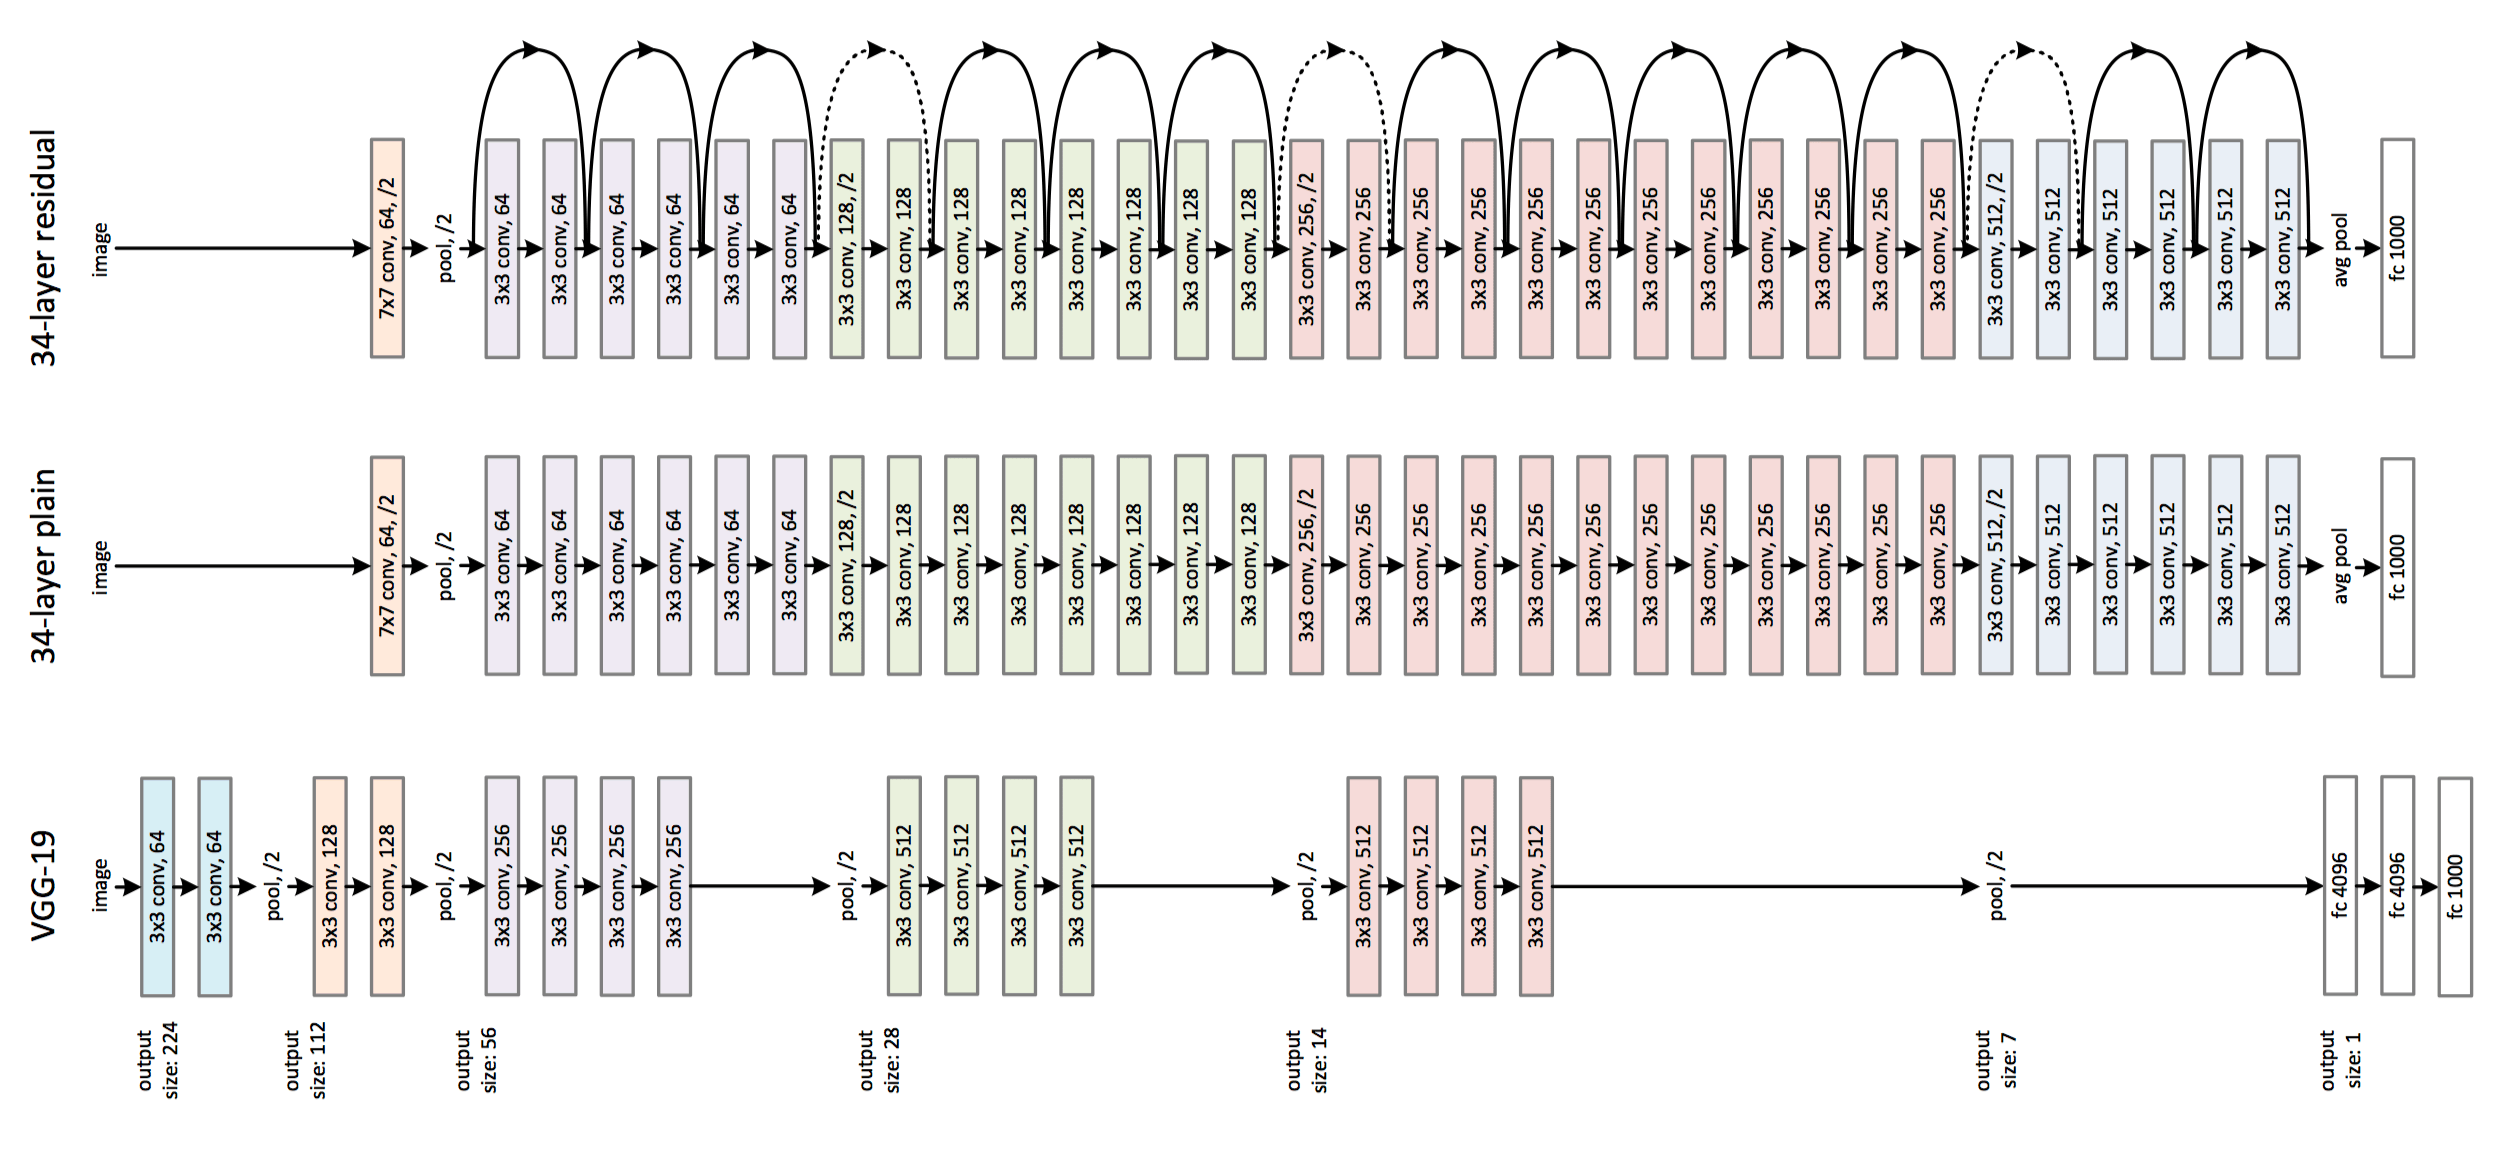

In [35]:
Image("resnet34.png")

В некоторых слоях **ResNet** используется **stride** = 2 (на картинке слои с "/2"), в этой архитектуре отказались от **max pooling** слоев и уменьшают размерность карт признаков с помощью шага = 2. Предположим, что на вход подаются карты признаков с размерами **W**, **H** (ширина и высота) и глубиной в 64 канала, а на выходе получаем тензор с размерами **W / 2**, **H / 2** и глубиной в 128 каналов. Получается, размеры полученного тензора не согласованы с размерами тензора, который приходит из **shortcut connection**. Чтобы все работало согласованно, нужно в **shortcut connection** добавить сверточный слой с размером ядра  **1x1**, со **stride** = 2 и количеством фильтров = 128.

# Модель ResNet в PyTorch

In [39]:
def downsample(in_channels, out_channels, stride=1):
    sequential = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(out_channels)
    )
    return sequential

class Bottleneck(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, middle_channels, 
                               kernel_size=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(middle_channels)
        
        self.conv2 = nn.Conv2d(middle_channels, middle_channels, 
                               kernel_size=3, 
                               stride=stride, 
                               padding=1, 
                               bias=False)
        self.bn2 = nn.BatchNorm2d(middle_channels)
        
        self.conv3 = nn.Conv2d(middle_channels, out_channels, 
                               kernel_size=1, 
                               bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
        
        if stride != 1 or in_channels != out_channels:
            self.downsample = downsample(in_channels, out_channels, stride)
        else:
            self.downsample = None
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample:
            identity = self.downsample(identity)
        
        out += identity
        out = self.relu(out)
        
        return out

In [40]:
Bottleneck(128, 64, 256, stride=2)(torch.randn(1, 128, 224, 224)).shape

torch.Size([1, 256, 112, 112])

In [43]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 
                               kernel_size=7, 
                               stride=2, 
                               padding=3, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, 
                                    stride=2, 
                                    padding=1)
        
        self.layer1 = nn.Sequential(
            Bottleneck(64, 64, 256),
            Bottleneck(256, 64, 256),
            Bottleneck(256, 64, 256)
        )
        
        self.layer2 = nn.Sequential(
            Bottleneck(256, 128, 512, stride=2),
            Bottleneck(512, 128, 512),
            Bottleneck(512, 128, 512),
            Bottleneck(512, 128, 512)
        )
        
        self.layer3 = nn.Sequential(
            Bottleneck(512, 256, 1024, stride=2),
            Bottleneck(1024, 256, 1024),
            Bottleneck(1024, 256, 1024),
            Bottleneck(1024, 256, 1024),
            Bottleneck(1024, 256, 1024),
            Bottleneck(1024, 256, 1024)
        )
        
        self.layer4 = nn.Sequential(
            Bottleneck(1024, 512, 2048, stride=2),
            Bottleneck(2048, 512, 2048),
            Bottleneck(2048, 512, 2048)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [47]:
ResNet50(2)(torch.randn(1, 3, 224, 224))

tensor([[-0.5763,  0.8380]], grad_fn=<AddmmBackward0>)

In [60]:
model = ResNet50(2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=10**(-6))
criterion = nn.CrossEntropyLoss().to(device)

In [79]:
for epoch in range(1, epochs+1):
    model.train()
    
    progress_bar = tqdm(train_loader,
                        leave=True if epoch == epochs else False,
                        unit="batch")
    
    mean_loss = 0
    m = 0
    
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        value = loss.item()
        m += 1
        mean_loss = 1/m * value + (1 - 1/m) * mean_loss
        
        text = f"[train] Epoch: [{epoch}/{epochs}] <Loss>: {mean_loss:.2f}|"
        progress_bar.set_description(text)

[train] Epoch: [3/3] <Loss>: 0.23|: 100%|███████████████████████████████████████| 1247/1247 [08:42<00:00,  2.39batch/s]


In [80]:
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
            
        outputs = model(images)
            
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)
            
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
        
accuracy = 100 * correct / total

100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [00:46<00:00,  6.76it/s]


In [81]:
accuracy

90.96554487179488

# Используем предобученную модель ResNet50

In [52]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model = model.requires_grad_(False)
model.fc = nn.Linear(2048, 2).requires_grad_(True)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=10**(-6))
criterion = nn.CrossEntropyLoss().to(device)

In [85]:
for epoch in range(1, epochs+1):
    model.train()
    
    progress_bar = tqdm(train_loader,
                        leave=True if epoch == epochs else False,
                        unit="batch")
    
    mean_loss = 0
    m = 0
    
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        value = loss.item()
        m += 1
        mean_loss = 1/m * value + (1 - 1/m) * mean_loss
        
        text = f"[train] Epoch: [{epoch}/{epochs}] <Loss>: {mean_loss:.2f}|"
        progress_bar.set_description(text)

[train] Epoch: [3/3] <Loss>: 0.07|: 100%|███████████████████████████████████████| 1247/1247 [04:36<00:00,  4.50batch/s]


In [119]:
model.eval()
total = 0
correct = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
            
        outputs = model(images)
            
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)
            
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
        
accuracy = 100 * correct / total

100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [00:47<00:00,  6.58it/s]


In [120]:
accuracy

98.91826923076923

# Важные особенности при обучении моделей

# [MixUp](https://pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py) - Data Augmentation

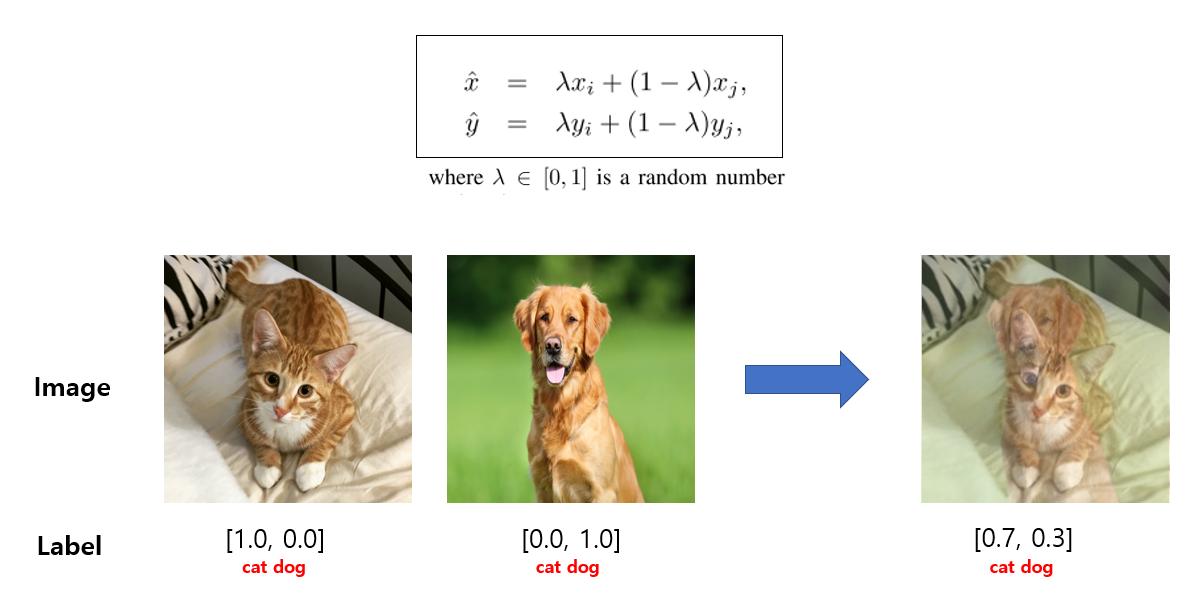

In [93]:
Image("mixup.png", width=900)

Если два примера принадлежат разным классам, их смешанный пример лежит где-то «между» ними. Это означает, что модель должна предсказывать, что объект принадлежит одновременно и к первому, и ко второму классу в некоторой пропорции. Такой подход помогает модели не запоминать конкретные примеры, а лучше обобщать информацию, так как она вынуждена работать с «смазанными» данными и приводит к более плавным разделениям между классами.

In [106]:
dog, y_dog = cv2.resize(cv2.imread("datasets/dogs_and_cats/test/1_12.jpg"), (300, 300)), np.array([0, 1])
cat, y_cat = cv2.resize(cv2.imread("datasets/dogs_and_cats/test/0_134.jpg"), (300, 300)), np.array([1, 0])

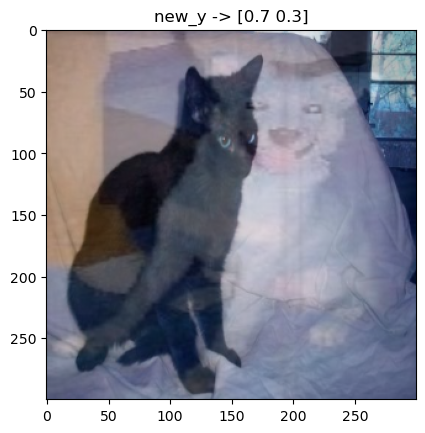

In [110]:
alpha = 0.7
plt.imshow( (alpha * cat + (1 - alpha) * dog) / 255 );
plt.title(f"new_y -> { alpha * y_cat + (1 - alpha) * y_dog }");

In [24]:
mixup = v2.MixUp(alpha=0.25,  # определяет форму бета-распределения, из которого извлекается коэффициент α
                 num_classes=2)

In [31]:
for images, labels in train_loader:
    images, labels = mixup(images, labels)
    break

In [32]:
labels[:10]

tensor([[0.0000, 1.0000],
        [0.0398, 0.9602],
        [0.9602, 0.0398],
        [0.0000, 1.0000],
        [0.0000, 1.0000],
        [0.0398, 0.9602],
        [0.9602, 0.0398],
        [0.0398, 0.9602],
        [0.9602, 0.0398],
        [0.0398, 0.9602]])

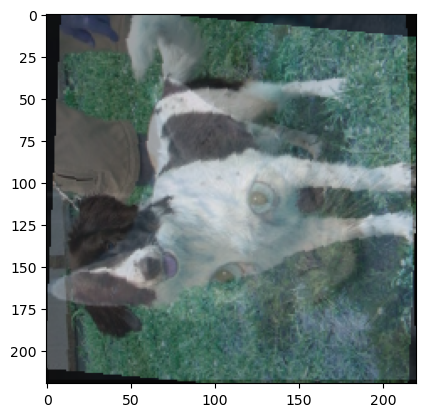

In [32]:
plt.imshow(images[0].permute(2, 1, 0));

# [Weight decay](https://arxiv.org/pdf/1711.05101)

Рассмотрим затухание весов (**weight decay**):

$θ_{k+1}=(1−λ)\cdot θ_k−α ∇f_k (θ_k)$, где **λ** задаёт скорость затухания, а **α** — скорость обучения.

Это соотношение оказывается эквивалентным **L2**-регуляризации $f_{reg}(θ)=f(θ)+\frac{λ_0}{2}{∥θ∥}^2$, если взять $λ_0=\,\frac{λ}{α}$. 

Получим $θ_{k+1}=θ_k−α \,[∇f_k (θ_k) + \frac{λ}{α}\cdotθ_k] = (1−λ)\cdot θ_k−α ∇f_k (θ_k)$

В статье приводится проблема, что для адаптивных оптимизаторов (например, Adam) **L2**-регуляризация работает не так, как хотелось бы. В Adam для каждого параметра используется индивидуальное масштабирование шага обновления, зависящее от накопленной информации о квадрате градиентов. Если мы добавляем **L2**-регуляризацию, то к градиенту от функции прибавляется градиент от регуляризующего члена. Таким образом, из-за того, что Adam адаптивно подбирает шаг для каждого параметра, подобранные шаги применяется и к регуляризующему члену, хотя предполагалось, что **L2**-регуляризация будет одинаково «сжимать» все веса, способствуя улучшению обобщающих способностей модели. Однако в случае Adam из-за адаптивного масштабирования параметры с большими историческими градиентами получают меньший вклад от регуляризатора, что приводит к неоднородности в регуляризации.

Чтобы избежать описанной проблемы, предлагается разделить шаг затухания весов от градиентного шага обновления. Для **Adam** получим:

$θ_{k+1}=θ_{k} - \frac{lr}{\sqrt{\overline{V_k}\,+\,ε}} \cdot \overline{M_k} - λ\cdot θ_k$, хотя раньше градиент от регуляризующего члена был в $\overline{M_k}$, что приводило к проблеме, которая описана выше.

Таким образом, появился **[AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)**.

# [Stochastic depth](https://pytorch.org/vision/main/generated/torchvision.ops.stochastic_depth.html#torchvision.ops.stochastic_depth)

Суть метода в том, чтобы с некой изначально заданной вероятностью выключать **basic** или **bottleneck** блоки в **ResNet**, чтобы во время обучения «сократить» сеть, пропуская некоторые остаточные блоки. При этом во время тестирования сеть используется целиком (все слои активны). В отличие от **Dropout** данный метод выключает целый блок, а не отдельно взятые нейроны. Как и в случае **Dropout**, нужно делать поправку $\frac{1}{1-p}$ ($p$ - вероятность выключить блок) для входных тензоров во время обучения, так как распределение данных во время обучения и тестирования будет разным.

В [статье](https://arxiv.org/pdf/1603.09382) предлагается вероятности выключения блоков увеличивать от начала сети до конца линейно (в начале нейронной сети наименьшая вероятность, в конце наибольшая):

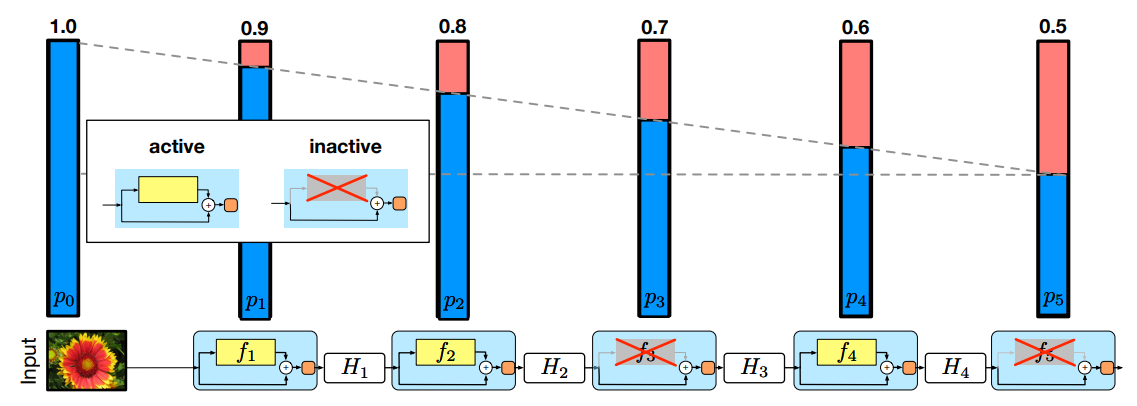

In [71]:
Image("stochastic_depth.png")

Метод имеет следующие преимущества:

- Ускоряет обучение, поскольку фактически уменьшается число активных слоёв.

- Улучшает распространение градиентов, так как сеть становится короче.

- Метод похож на **Dropout**, поэтому действует как регуляризация, позволяя избежать переобучения.

In [82]:
x = torch.randn(2, 2, 1, 3)

In [83]:
x

tensor([[[[-0.2062,  0.4012,  0.7492]],

         [[-0.4885,  1.2553,  1.3530]]],


        [[[ 2.0051, -0.5702,  0.3004]],

         [[ 0.2729, -0.9007, -0.6166]]]])

In [91]:
ops.stochastic_depth(x, p=0.5, mode="batch")

tensor([[[[-0., 0., 0.]],

         [[-0., 0., 0.]]],


        [[[0., -0., 0.]],

         [[0., -0., -0.]]]])

In [92]:
ops.stochastic_depth(x, p=0.5, mode="row")

tensor([[[[-0.0000,  0.0000,  0.0000]],

         [[-0.0000,  0.0000,  0.0000]]],


        [[[ 4.0103, -1.1404,  0.6008]],

         [[ 0.5458, -1.8015, -1.2332]]]])

# [Bag of Tricks](https://arxiv.org/pdf/1812.01187)

- Градиент зависит от размера батча, чем больше батч, на котором считается градиент, тем менее шумным будет градиент. Соответственно, если размер батча увеличивается в **n** раз, то **learning rate** тоже можно увеличить в **n** раз.

- **Warmup**. В начале обучения параметры находятся далеко от оптимального решения. Если сразу использовать высокий learning rate, это может привести к числовой нестабильности. Поэтому на начальных этапах (например, первые 5 эпох) используют постепенное (линейное) увеличение learning rate от 0 до заданного значения. 

- **Cosine learning rate decay**

- **No bias decay** - не включать веса смещений (bias) в регуляризацию **weight decay**

- **Zero γ in Batch Norm** - инициализировать нулем $γ$ и $β$ для блоков в формуле **Batch Norm**: $\frac{x-μ}{\sqrt{σ^2+ε}}\cdot γ + β$. Это делается для того, чтобы в начале обучения **Residual** блоки выдавали вход, то есть оставался только **skip connection**, а в последствии, если сети все же необходимы соответствующие слои, она сможет в процессе обучения подобрать нужный $γ$, чтобы слои не занулялись. Этот метод делает сеть эффективнее на начальных этапах, так как она фактически «короче», из-за чего упрощается распространение градиента.

- **Label Smoothing**

# Применение новых техник

In [163]:
from torchvision.models.resnet import ResNet, Bottleneck

In [164]:
ResNet(Bottleneck, [1, 1, 1, 1]);  # ResNet из Bottleneck блоков, где каждый layer имеет 1 такой блок.

# Bottleneck c применением stochastic depth

In [165]:
class BottleneckSD(Bottleneck):
    def __init__(self, *args, drop_prob=0.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.drop_prob = drop_prob

    def forward(self, x):
        identity = x
        
        if self.downsample is not None:
            identity = self.downsample(x)

        if self.training and torch.rand(1).item() < self.drop_prob:  # Условие на то, будет ли сеть использовать блок
            return identity
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.training:
            out = out / (1 - self.drop_prob)  # Добавляется поправка в случае тренировки модели
        
        out += identity
        out = self.relu(out)
        return out

# Resnet152 c новыми BottleneckSD блоками

In [166]:
class ResNet152SD(ResNet):
    def __init__(self, drop_prob=0, **kwargs):
        super().__init__(BottleneckSD, [3, 8, 36, 3], **kwargs)
        total_blocks = sum([8, 36, 3])
        block_id = 1
        for layer in [self.layer2, self.layer3, self.layer4]:  # drop probability increases linearly for a part of the layers
            for i in range(len(layer)):
                current_drop_prob = drop_prob * float(block_id) / total_blocks
                layer[i].drop_prob = current_drop_prob
                block_id += 1

# Загрузка весов предобученной модели

In [15]:
pretrained_model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
model = ResNet152SD(drop_prob=0.15)
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [168]:
epochs = 5

# Заморозка части слоев

In [169]:
model.requires_grad_(False);

for layer in [model.layer2, model.layer3, model.layer4, model.fc]:
    layer.requires_grad_(True)

In [170]:
model.fc = nn.Linear(2048, 2).requires_grad_(True)
model = model.to(device)

# Убираем регуляризацию weight decay для bias 

In [171]:
decay = dict()
no_decay = dict()
for name, param in model.named_parameters():
    if 'weight' in name:
        decay[name] = param
    else:
        no_decay[name] = param

In [172]:
layer2_weights = []
layer3_weights = []
layer4_weights = []
fc_weights = []
for name, weight in decay.items():
    if "layer2" in name:
        layer2_weights.append(weight)
    elif "layer3" in name:
        layer3_weights.append(weight)
    elif "layer4" in name:
        layer4_weights.append(weight)
    elif "fc" in name:
        fc_weights.append(weight)
    else:
        print(f"{name} is not included!")

conv1.weight is not included!
bn1.weight is not included!
layer1.0.conv1.weight is not included!
layer1.0.bn1.weight is not included!
layer1.0.conv2.weight is not included!
layer1.0.bn2.weight is not included!
layer1.0.conv3.weight is not included!
layer1.0.bn3.weight is not included!
layer1.0.downsample.0.weight is not included!
layer1.0.downsample.1.weight is not included!
layer1.1.conv1.weight is not included!
layer1.1.bn1.weight is not included!
layer1.1.conv2.weight is not included!
layer1.1.bn2.weight is not included!
layer1.1.conv3.weight is not included!
layer1.1.bn3.weight is not included!
layer1.2.conv1.weight is not included!
layer1.2.bn1.weight is not included!
layer1.2.conv2.weight is not included!
layer1.2.bn2.weight is not included!
layer1.2.conv3.weight is not included!
layer1.2.bn3.weight is not included!


In [173]:
layer2_bias = []
layer3_bias = []
layer4_bias = []
fc_bias = []
for name, weight in no_decay.items():
    if "layer2" in name:
        layer2_bias.append(weight)
    elif "layer3" in name:
        layer3_bias.append(weight)
    elif "layer4" in name:
        layer4_bias.append(weight)
    elif "fc" in name:
        fc_bias.append(weight)
    else:
        print(f"{name} is not included!")

bn1.bias is not included!
layer1.0.bn1.bias is not included!
layer1.0.bn2.bias is not included!
layer1.0.bn3.bias is not included!
layer1.0.downsample.1.bias is not included!
layer1.1.bn1.bias is not included!
layer1.1.bn2.bias is not included!
layer1.1.bn3.bias is not included!
layer1.2.bn1.bias is not included!
layer1.2.bn2.bias is not included!
layer1.2.bn3.bias is not included!


# Для каждой группы параметров свой weight_decay в оптимизаторе

In [174]:
"""optimizer = optim.AdamW([
    {"params": model.layer2.parameters(), "lr": 10**(-6)},
    {"params": model.layer3.parameters(), "lr": 10**(-5)},
    {"params": model.layer4.parameters(), "lr": 10**(-4)},
    {"params": model.fc.parameters(), "lr": 10**(-3)},
], weight_decay=10**(-5))"""

optimizer = optim.AdamW([
    {"params": layer2_weights, "lr": 10**(-6)},
    {"params": layer3_weights, "lr": 10**(-5)},
    {"params": layer4_weights, "lr": 10**(-4)},
    {"params": fc_weights, "lr": 10**(-3)},
    {"params": layer2_bias, "lr": 10**(-6), "weight_decay": 0},
    {"params": layer3_bias, "lr": 10**(-5), "weight_decay": 0},
    {"params": layer4_bias, "lr": 10**(-4), "weight_decay": 0},
    {"params": fc_bias, "lr": 10**(-3), "weight_decay": 0}
], weight_decay=10**(-4))

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*2)
criterion = nn.CrossEntropyLoss().to(device)

In [25]:
for epoch in range(1, epochs+1):
    model.train()
    
    progress_bar = tqdm(train_loader,
                        leave=False,
                        unit="batch")
    
    mean_loss = 0
    m = 0
    
    for images, labels in progress_bar:
        images, labels = mixup(images, labels)
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        value = loss.item()
        m += 1
        mean_loss = 1/m * value + (1 - 1/m) * mean_loss
        
        text = f"[train] Epoch: [{epoch}/{epochs}] <Loss>: {mean_loss:.2f}|"
        progress_bar.set_description(text)
    
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            predicted = torch.argmax(outputs, dim=1)
            labels = torch.argmax(labels, dim=1)

            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}")

100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [01:46<00:00,  2.92it/s]


Accuracy: 99.53926282051282


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [01:39<00:00,  3.13it/s]


Accuracy: 99.63942307692308


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [01:39<00:00,  3.13it/s]


Accuracy: 99.63942307692308


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [01:39<00:00,  3.14it/s]


Accuracy: 99.65945512820512


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [01:39<00:00,  3.13it/s]

Accuracy: 99.61939102564102


# [EfficientNet](https://arxiv.org/pdf/1905.11946)

Обычно сверточные нейронные сети разрабатываются с учётом фиксированного бюджета вычислительных ресурсов, а затем «масштабируются» (увеличиваются в размере) для повышения точности, если появляются дополнительные возможности. При этом традиционно масштабирование проводится по одной из трёх осей:

- Глубина: увеличение числа слоёв (например, переход от ResNet-18 к ResNet-200).

- Ширина: увеличение количества каналов.

- Разрешение входного изображения: увеличение размеров входного изображения для извлечения более детальной информации.

Исследования авторов показали, что для достижения наилучших результатов необходимо сбалансированное увеличение всех трёх параметров. Если увеличить лишь одно измерение, это не даст оптимального эффекта, причем после некоторого количества увеличении одного из показателей происходит насыщение, то есть точность начинает расти незначительно.

Экспериментально было установлено, что увеличение разрешения требует одновременно увеличения глубины (для большего поля восприятия) и ширины (для захвата тонких деталей). То есть, масштабирование по разным измерениям взаимосвязано и должно проводиться сбалансированно. Авторы вводят понятие «compound scaling», которое заключается в равномерном масштабировании глубины, ширины и разрешения входного изображения с помощью заранее определённых коэффициентов.

Предлагается использовать один параметр $ϕ$, который равномерно масштабирует все измерения:

- Глубина: $d=α^{\,ϕ}$

- Число фильтров: $w=β^{\,ϕ}$

- Разрешение: $r=γ^{\,ϕ}$

При этом накладывается ограничение: $α⋅β^2⋅γ^2≈2$.

Параметр $ϕ$ контролирует, сколько дополнительных ресурсов можно задействовать для масштабирования.

Важно, что количество операций (FLOPS) в свёрточном слое пропорционально $d⋅w^{\,2}⋅r^{\,2}$. 

- Удвоение глубины удваивает FLOPS;

- Удвоение ширины или разрешения увеличивает FLOPS в 4 раза. Так как увеличивается и число входных каналов и число выходных каналов (фильтров) в 2 раза и увеличивается и ширина, и высота изображения, поэтому происходит увеличение в 4 раза. 

Поэтому, если условие $α⋅β^2⋅γ^2≈2$ выполняется, то увеличение $ϕ$ на 1 приведёт к приближенному удвоению общего числа операций: 

$d⋅w^{\,2}⋅r^{\,2} = α^{\,ϕ} ⋅ β^{\,2ϕ} ⋅ γ^{\,2ϕ} = [α^{\,} ⋅ β^{\,2} ⋅ γ^{\,2}]^{ϕ} ≈ 2^{\,ϕ}$

Это позволяет удобно масштабировать модель, зная, как изменится вычислительная нагрузка.

Интуитивное обоснование метода. При увеличении разрешения изображения требуется:

- Больше слоёв, чтобы увеличить область восприятия (receptive field) сети.

 - Больше каналов для захвата более мелких деталей.

Таким образом, увеличение каждой из трёх составляющих приводит к более сбалансированному и эффективному извлечению признаков.

Авторы разработали новую базовую модель - **EfficientNet-B0**.

Базовая модель построена на модуле MBConv (mobile inverted bottleneck), который дополнительно усовершенствован с помощью squeeze-and-excitation блоков. Для масштабирования базовой модели авторы используют предложенный метод комплексного масштабирования в два этапа:

- **Этап 1.** При фиксированном значении $ϕ$ = 1 проводится небольшой перебор коэффициентов $α$, $β$ и $γ$ согласно формулам $d=α^{\,ϕ}$, $w=β^{\,ϕ}$ и $r=γ^{\,ϕ}$ при условии, что $α⋅β^2⋅γ^2≈2$. Для **EfficientNet-B0** оптимальными оказались значения: $α=1.2$, $β = 1.1$ и $γ = 1.15$.

- **Этап 2.** После определения коэффициентов они фиксируются, а базовая модель масштабируется для получения серии **[EfficientNet-B1 ... B7](https://pytorch.org/vision/main/models/efficientnet.html)** путём изменения $ϕ$.

Такой подход позволяет выполнить масштабирование, проводя поиск коэффициентов лишь один раз на небольшой базовой сети, а затем применять их ко всем последующим моделям, что существенно снижает вычислительные затраты на поиск оптимальных параметров для крупных моделей.

# Архитектура EfficientNet

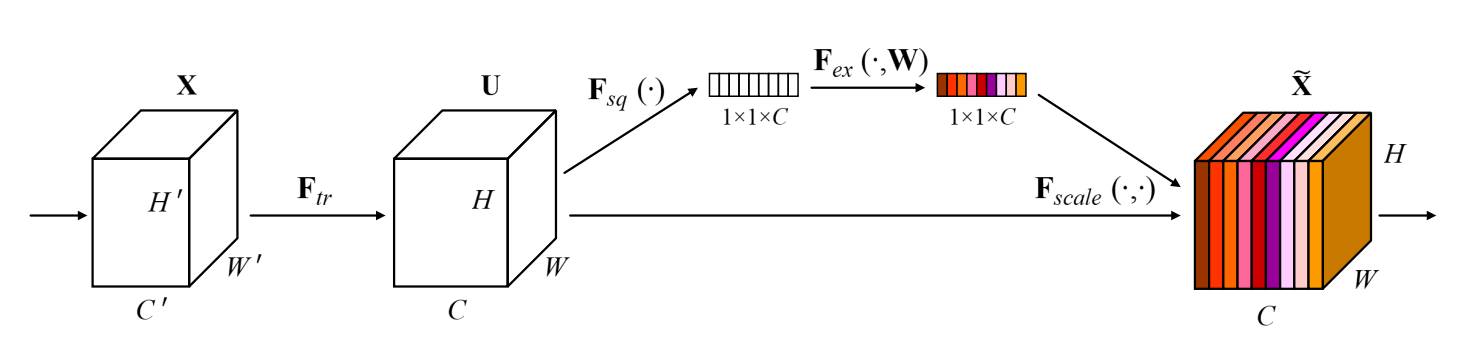

In [13]:
Image("squeeze-and-excitation.png")

Первый слой получает на вход изображение (3 канала) и выполняет свёртку с ядром **3x3** и шагом 2, чтобы уменьшить размерность изображения.

В основе архитектуры лежат блоки **MBConv**:

- **Этап расширения**: Если коэффициент расширения **expand_ratio > 1**, входные данные сначала проходят через точечную **1x1** свёртку, которая увеличивает число каналов (например, в 6 раз). Это позволяет получить богатое представление признаков.

- **Depthwise свёртка**: Затем применяется свёртка с ядром (например, **3x3** или **5x5**) с параметром **groups=channels**, то есть каждый канал обрабатывается отдельно своим фильтром.

- **Squeeze-and-Excitation**: После **depthwise** свёртки блок **SE** сначала выполняет глобальное усреднение каждого канала, затем через два маленьких полносвязных слоя (реализованных как свёртки **1x1**) с функциями активации (**SiLU** и **Sigmoid**) вычисляет коэффициенты для масштабирования каналов. На выходе слоя получается вектор, где каждый элемент лежит в интервале (0, 1) и все эти значения умножаются на соответствующие каналы. Это позволяет сети выделять наиболее важные признаки.

- **Проекционный слой**: После **SE**-блока данные сжимаются точечной свёрткой **1x1** до требуемого числа выходных каналов. Если размерность входа совпадает с выходом и шаг равен 1, используется остаточное соединение (**skip connection**).

В **EfficientNet** всего  7 последовательностей блоков **MBConv**, где сочетается различное число таких блоков.

**Почему это вообще работает?**

Обычный свёрточный слой одновременно обрабатывает как пространственную информацию внутри одного канала, так и межканальную информацию, так как свёртка применяется ко всем каналам сразу. Блоки **MBConv** базируется на предположении о том, что эти два вида информации можно обрабатывать последовательно без потери качества работы сети, поэтому обычная свёртка раскладывается на **pointwise convolution** (которая обрабатывает только межканальную информацию) и **spatial convolution** (которая обрабатывает только пространственную информацию в рамках отдельного канала). Такой способ сильно уменьшает число параметров модели.

In [433]:
class Conv2dNormActivation(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, groups=1, activation_layer=True):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True)
        ]
        layers = layers if activation_layer else layers[:-1]  # Нужна функция активации или нет
        
        super().__init__(*layers)

        
class SqueezeExcitation(nn.Module):
    def __init__(self, input_channels, squeeze_factor=4, activation=nn.SiLU):
        super().__init__()
        squeeze_channels = input_channels // squeeze_factor
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(input_channels, squeeze_channels, kernel_size=1)
        self.fc2 = nn.Conv2d(squeeze_channels, input_channels, kernel_size=1)
        self.activation = activation(inplace=True)
        self.scale_activation = nn.Sigmoid()
    
    def forward(self, x):
        scale = self.avgpool(x)
        scale = self.fc1(scale)
        scale = self.activation(scale)
        scale = self.fc2(scale)
        scale = self.scale_activation(scale)
        return x * scale


class MBConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio=4, drop_prob=0.0):
        super().__init__()
        hidden_dim = in_channels * expand_ratio  # Расширение числа каналов в expand_ratio раз
        self.use_residual = (stride == 1 and in_channels == out_channels)  # Используется ли Residual connection
        
        layers = []

        if expand_ratio != 1:  # Добавляется дополнительный слой, который увеличивает число каналов сверткой 1x1
            layers.append(Conv2dNormActivation(in_channels, hidden_dim, kernel_size=1, stride=1, padding=0))

        layers.append(Conv2dNormActivation(hidden_dim, hidden_dim, kernel_size=kernel_size, stride=stride,
                                           padding=kernel_size // 2, groups=hidden_dim))

        if se_ratio is not None and se_ratio > 0:
            layers.append(SqueezeExcitation(hidden_dim, squeeze_factor=se_ratio))
        
        layers.append(Conv2dNormActivation(hidden_dim, out_channels, kernel_size=1, stride=1, padding=0, activation_layer=None))
        
        self.block = nn.Sequential(*layers)
        self.stochastic_depth = ops.StochasticDepth(p=drop_prob, mode="row")
    
    def forward(self, x):
        out = self.block(x)
        out = self.stochastic_depth(out)
        if self.use_residual:
            out = out + x
        return out


class EfficientNet(nn.Module):
    def __init__(self, num_classes=1000, drop_prob=0.2):
        super().__init__()

        features = []
        
        features.append(Conv2dNormActivation(3, 32, kernel_size=3, stride=2, padding=1))
        
        # Параметры блоков (конфигурация из статьи EfficientNet-B0)
        # Каждый кортеж: 
        # (Размер фильтров, 
        #  Количество блоков, 
        #  Количество входных каналов, 
        #  Количество выходных каналов, 
        #  Коэффициент расширения, 
        #  Шаг свёртки, 
        #  Отношение для squeeze-and-excitation)
        blocks_args = [
            (3, 1, 32, 16, 1, 1, 4),
            (3, 2, 16, 24, 6, 2, 24),
            (5, 2, 24, 40, 6, 2, 24),
            (3, 3, 40, 80, 6, 2, 24),
            (5, 3, 80, 112, 6, 1, 24),
            (5, 4, 112, 192, 6, 2, 24),
            (3, 1, 192, 320, 6, 1, 24),
        ]
          
        total_blocks = sum(t[1] for t in blocks_args)
        block_id = 0
        for kernel_size, num_repeat, in_channels, out_channels, expand_ratio, stride, se_ratio in blocks_args:
            blocks = []
            for i in range(num_repeat):
                s = stride if i == 0 else 1  # Первый блок в группе может иметь шаг = 2
                drop_rate = drop_prob * block_id / total_blocks
                blocks.append(MBConv(in_channels, out_channels, kernel_size, s, expand_ratio, se_ratio, drop_prob=drop_rate))
                in_channels = out_channels
                block_id += 1
                
            features.append(nn.Sequential(*blocks))
        
        # Завершающая свёртка, переводящая число каналов в 1280
        features.append(Conv2dNormActivation(320, 1280, kernel_size=1, stride=1, padding=0))
        self.features = nn.Sequential(*features)
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(drop_prob, inplace=True),
            nn.Linear(1280, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [434]:
pretrained_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model = EfficientNet()
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [435]:
model.__str__() == models.efficientnet_b0().__str__()  # модели по структуре полностью совпадают

True

# Обучение предобученной модели EfficientNet

In [306]:
model = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.DEFAULT)

In [17]:
epochs = 5

In [161]:
model.requires_grad_(False);

for layer in [model.features[6], model.features[7], model.features[8], model.classifier]:
    layer.requires_grad_(True)

In [20]:
model.classifier[1] = nn.Linear(1792, 2).requires_grad_(True)
model = model.to(device)

In [21]:
optimizer = optim.AdamW([
    {"params": model.features[6].parameters(), "lr": 10**(-6)},
    {"params": model.features[7].parameters(), "lr": 10**(-5)},
    {"params": model.features[8].parameters(), "lr": 10**(-4)},
    {"params": model.classifier.parameters(), "lr": 10**(-3)},
], weight_decay=10**(-5))

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs*2)
criterion = nn.CrossEntropyLoss().to(device)

In [22]:
for epoch in range(1, epochs+1):
    model.train()
    
    progress_bar = tqdm(train_loader,
                        leave=False,
                        unit="batch")
    
    mean_loss = 0
    m = 0
    
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        scheduler.step()
        
        value = loss.item()
        m += 1
        mean_loss = 1/m * value + (1 - 1/m) * mean_loss
        
        text = f"[train] Epoch: [{epoch}/{epochs}] <Loss>: {mean_loss:.2f}|"
        progress_bar.set_description(text)
    
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            predicted = torch.argmax(outputs, dim=1)
            labels = torch.argmax(labels, dim=1)

            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}")

100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [01:49<00:00,  2.86it/s]


Accuracy: 99.47916666666667


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [01:43<00:00,  3.02it/s]


Accuracy: 99.31891025641026


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [01:44<00:00,  2.99it/s]


Accuracy: 99.39903846153847


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [01:45<00:00,  2.94it/s]


Accuracy: 99.45913461538461


100%|████████████████████████████████████████████████████████████████████████████████| 312/312 [01:52<00:00,  2.78it/s]

Accuracy: 99.35897435897436


# Интерпретация модели

Рассмотрим градиент выходной оценки класса относительно входных значений пикселей изображения. Пиксели, для которых этот градиент будет большим (положительным или отрицательным) — это пиксели, которые нужно изменить меньше всего, чтобы максимально повлиять на оценку класса. Можно ожидать, что такие пиксели соответствуют местоположению объекта на изображении.

In [177]:
model.eval()
model = model.requires_grad_(False)

In [300]:
data = test_dataset[55][0]
img = data.unsqueeze(0).to(device).requires_grad_(True)

In [301]:
scores = model(img)

score_max_index = scores.argmax()  # выбираем класс с максимальным значением
score_max = scores[0,score_max_index]

In [302]:
score_max.backward()

In [303]:
saliency, _ = torch.max(img.grad.data.abs(),dim=1)

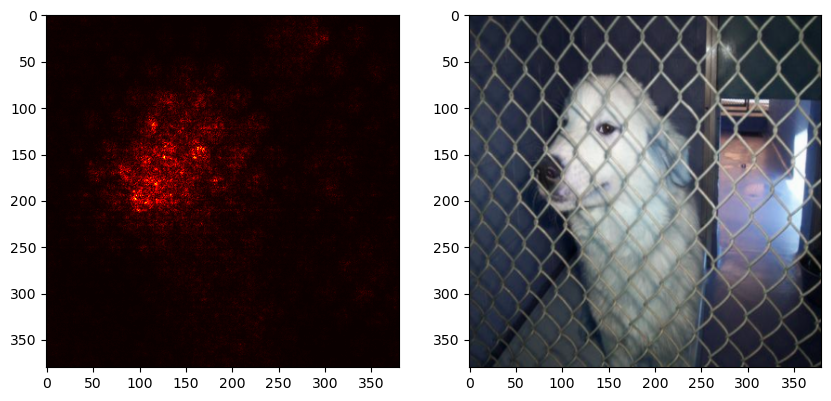

In [182]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(saliency[0].cpu(), cmap=plt.cm.hot);
plt.subplot(1, 2, 2)
plt.imshow(data.permute(1, 2, 0)*0.99);

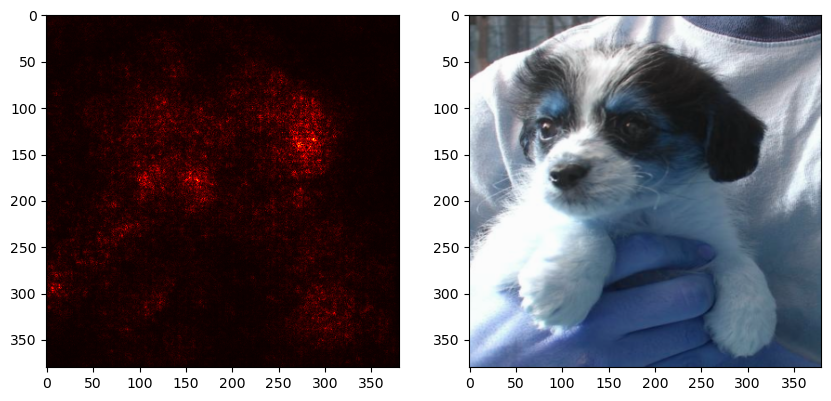

In [304]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(saliency[0].cpu(), cmap=plt.cm.hot);
plt.subplot(1, 2, 2)
plt.imshow(data.permute(1, 2, 0)*0.99);

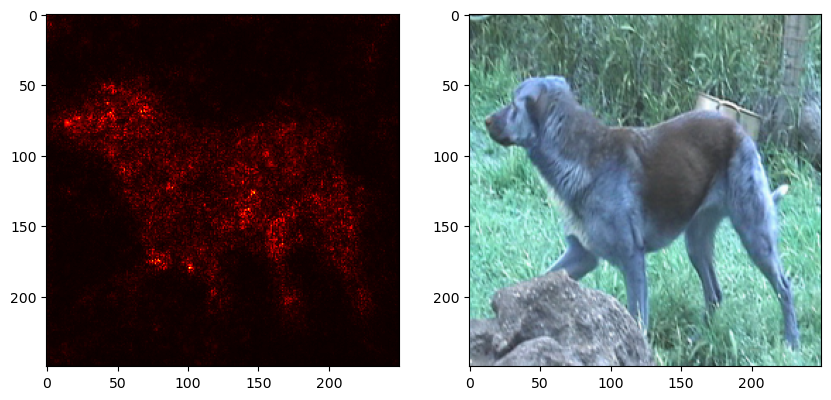

In [212]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(saliency[0].cpu(), cmap=plt.cm.hot);
plt.subplot(1, 2, 2)
plt.imshow(data.permute(1, 2, 0)*0.99);